In [4]:
import numpy as np
from tqdm import tqdm

# グローバルでシードを設定
np.random.seed(42)

#####################################
# Set parameters
#####################################
fiber_length = 2  # Fiber length (m)
# width = 200e-6  # Fiber core width  (m)
width =1e-5
nref = 1.4611  # Fiber refractive index
na = 0.39  # N.A.

lw0 = 1547.72  * 1e-9  # center wavelgnth (m)
c = 3.0e8  # light velocity (m/s)
omega0 = 2.0 * np.pi * c / lw0  # angular frequency (rad/s)
kw = omega0 / c  # wavenumber (1/m)

####### Spatial sampling ###
# num_x_pixel = 200
# num_y_pixel = 200
# dx = width / num_x_pixel
# dy = width / num_y_pixel
# x = np.arange(1, num_x_pixel + 1) * dx
# y = np.arange(1, num_y_pixel + 1) * dy

####### Input signal ######
# time_length = 10  # Time length of input signal
dt_w = 0.04e-9  # Time interval of input signal (s)
dt_samp = 0.02e-9  # Sampling time interval (s)
al = 2.0 * np.pi  # Input signal amplitude
num_repeat = int(dt_w / dt_samp)  # number of repeat


######################################
# Fixed parameters
######################################
def generate_mask_pattern(
    time_length=10, num_x_pixel_true=200, num_y_pixel_true=200
) -> np.ndarray:  # (time_length, num_x_pixel, num_y_pixel)
    ####### Spatial sampling ###
    num_x_pixel = num_x_pixel_true + 1
    num_y_pixel = num_y_pixel_true + 1
    dx = width / num_x_pixel
    dy = width / num_y_pixel
    x = np.arange(1, num_x_pixel + 1) * dx
    y = np.arange(1, num_y_pixel + 1) * dy
    # ----------- Multimode fiber --------------
    V_number = (np.pi * width / lw0) * na  # normalized frequency
    num_sq_modes = int(np.sqrt(0.5 * V_number * V_number))
    num_modes = num_sq_modes * num_sq_modes  # num. of excited modes

    # xy wavenumbers
    kx = np.linspace(1, num_sq_modes, num_sq_modes) * (np.pi / width)
    ky = np.linspace(1, num_sq_modes, num_sq_modes) * (np.pi / width)

    # beta wavenumbers & mode patterns
    _beta = np.zeros(num_modes)
    _psi = np.zeros((num_modes, num_x_pixel, num_y_pixel))
    for i in range(num_sq_modes):
        for j in range(num_sq_modes):
            m = num_sq_modes * i + j
            _beta[m] = np.sqrt(nref * nref * kw * kw - kx[i] * kx[i] - ky[j] * ky[j])
            _psi[m, :, :] = np.matmul(
                np.array(
                    [
                        np.sin(kx[i] * x),
                    ]
                ).T,
                np.array(
                    [
                        np.sin(ky[j] * y),
                    ]
                ),
            )

    # sorting
    beta = np.sort(_beta)
    psi = _psi[np.argsort(_beta), :, :]

    # dispersion, d\beta/d\omega
    disp = ((nref * nref) / (c * c)) * omega0 / beta
    # time delay
    time_delay = disp * fiber_length
    # relative time delay
    relative_time_delay = time_delay - time_delay[0]
    # index
    i_delay = relative_time_delay / dt_samp
    i_delay = i_delay.astype(int)

    # mode amplitudes
    aa = np.random.uniform(-1.0, 1.0, num_modes) + 1j * np.random.uniform(
        -1.0, 1.0, num_modes
    )
    aa = aa * np.exp(1j * beta * fiber_length)

    # Input signal
    _uu = np.random.uniform(-1.0, 1.0, int(time_length / num_repeat))
    uu = al * np.repeat(_uu, num_repeat)

    # time delay
    uu_delay = np.zeros((num_modes, time_length))
    for m in range(num_modes):
        uu_delay[m] = np.roll(uu, i_delay[m])
    # phase modulated input singal
    phase_modulated_input = np.exp(1j * uu_delay)

    # speckle field
    mask_speckles = np.zeros((time_length, num_x_pixel, num_y_pixel)) * 1j
    for n in tqdm(range(time_length)):
        for m in range(num_modes):
            mask_speckles[n, :, :] += aa[m] * psi[m, :, :] * phase_modulated_input[m, n]

    mask_patterns = np.abs(mask_speckles) ** 2
    # oversampling
    # print(mask_patterns.shape)
    mask_patterns_cropped = mask_patterns.astype(float)[
        :, :num_x_pixel_true, :num_y_pixel_true
    ]
    mask_patterns_normalized = mask_patterns_cropped / np.mean(mask_patterns_cropped)

    # save mask_patterns as npz
    np.savez(
        "mp_154772_2m_1e05.npz",
        mask_patterns_normalized,
    )
    print("Saved!")
    return mask_patterns_normalized


In [5]:
mask = generate_mask_pattern(time_length=2500, num_x_pixel_true=28, num_y_pixel_true=28)

100%|██████████| 2500/2500 [00:00<00:00, 16948.46it/s]

Saved!


In [4]:
mask.shape

(2500, 28, 28)

In [7]:
wave1 = np.load("mp_155012_2m_1e05.npz")["arr_0"]
wave2 = np.load("mp_154932_2m_1e05.npz")["arr_0"]
wave3 = np.load("mp_154852_2m_1e05.npz")["arr_0"]
wave4 = np.load("mp_154772_2m_1e05.npz")["arr_0"]

wave_multi_4 = np.concatenate([wave1, wave2, wave3, wave4], axis=0)
print(wave_multi_4.shape)
np.savez("wave_multi_4_2m_1e-5.npz", wave_multi_4)

(10000, 28, 28)


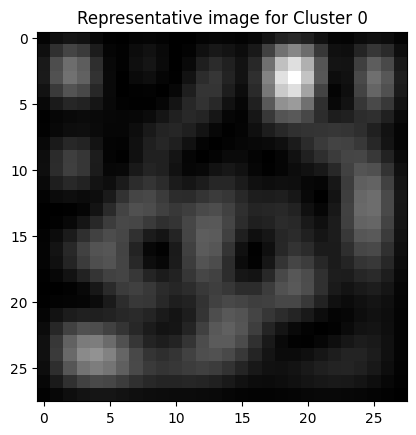

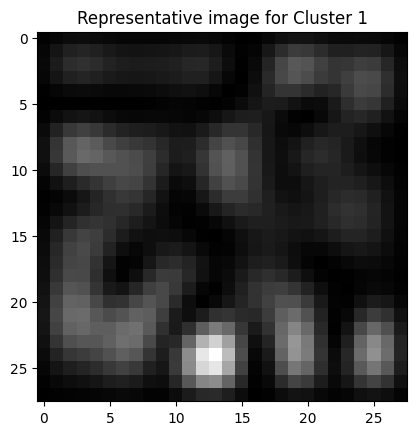

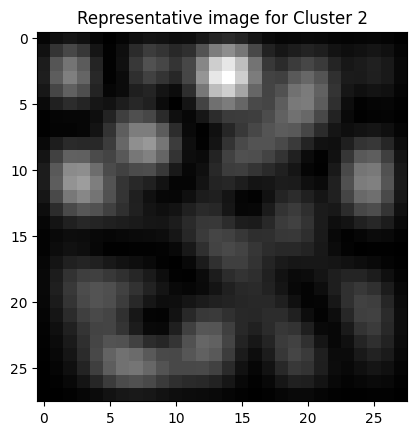

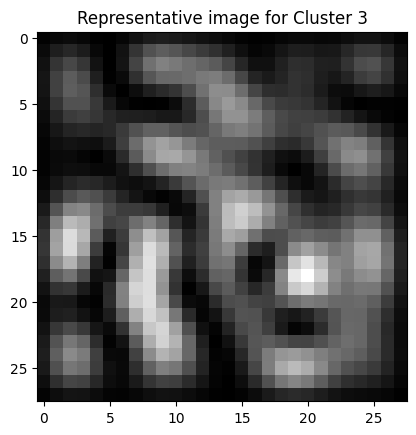

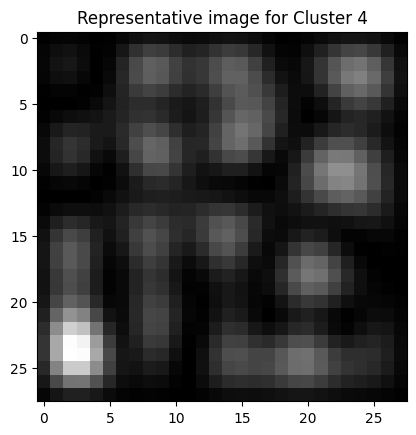

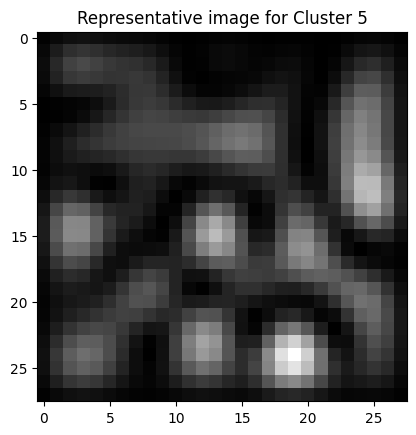

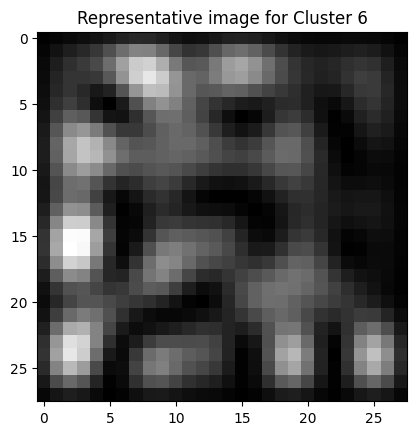

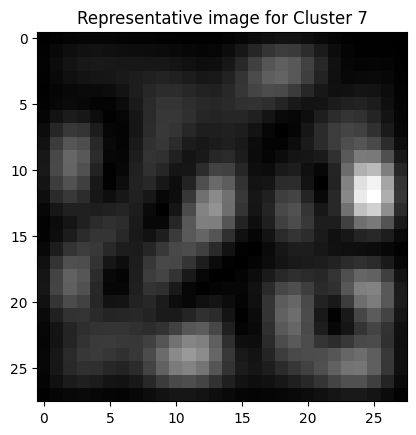

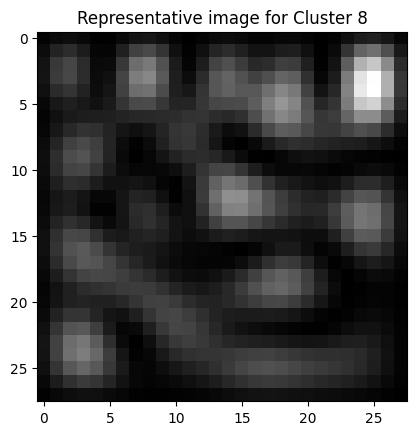

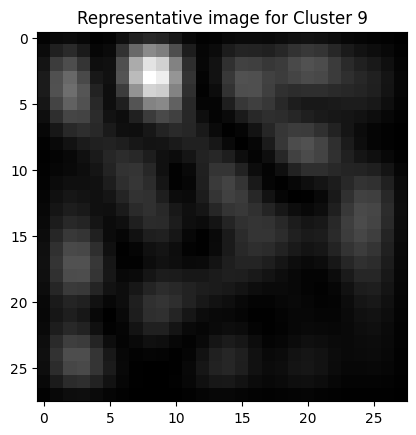

In [8]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# データを平坦化
flattened_data = wave_multi_4.reshape(10000, 28*28)

# K-meansでクラスタリング
n_clusters = 10  # クラスタ数（調整可能）
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(flattened_data)

# 各クラスタの代表的な画像を表示
for i in range(n_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 0:
        # クラスタの中心に最も近い画像を選択
        center_idx = cluster_indices[0]
        for idx in cluster_indices:
            if np.linalg.norm(flattened_data[idx] - kmeans.cluster_centers_[i]) < \
               np.linalg.norm(flattened_data[center_idx] - kmeans.cluster_centers_[i]):
                center_idx = idx
        
        plt.figure()
        plt.imshow(wave_multi_4[center_idx], cmap='gray')
        plt.title(f'Representative image for Cluster {i}')
        plt.show()

In [12]:
wave_multi_4.shape

(10000, 28, 28)

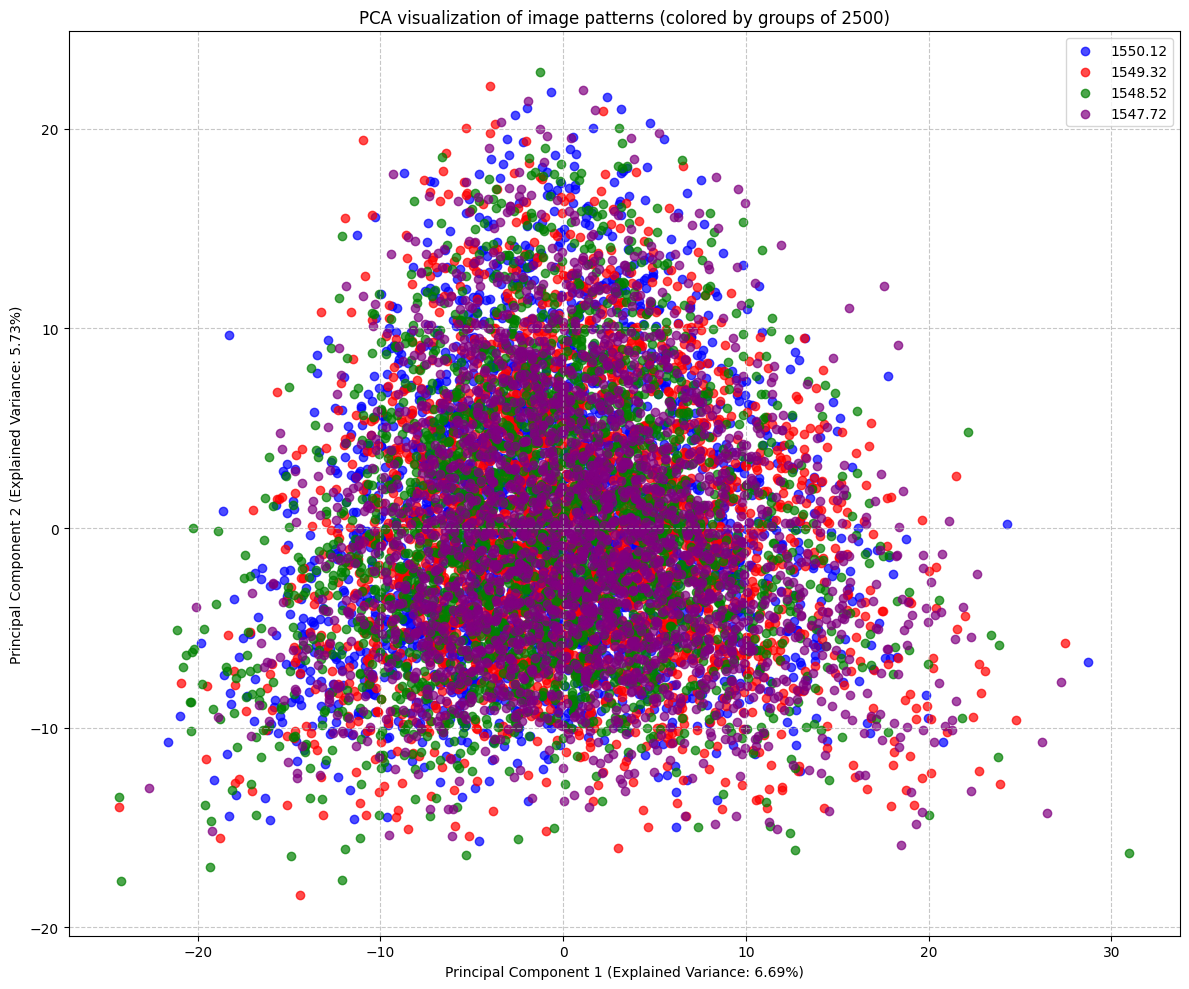

Cumulative explained variance by 2 components: 12.42%


In [14]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# サンプルデータ (実際のデータに置き換えてください)

data = wave_multi_4
# データを平坦化 (10000, 784)
flattened_data = data.reshape(10000, 28*28)

# PCAで2次元に削減
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_data)

# プロット
plt.figure(figsize=(12, 10))

# 2500枚ごとに色を変える (4グループ)
colors = ['blue', 'red', 'green', 'purple']
labels = ['1550.12', '1549.32', '1548.52', '1547.72']

for i in range(4):
    start_idx = i * 2500
    end_idx = (i + 1) * 2500
    plt.scatter(
        pca_result[start_idx:end_idx, 0], 
        pca_result[start_idx:end_idx, 1],
        c=colors[i],
        label=labels[i],
        alpha=0.7
    )

plt.title('PCA visualization of image patterns (colored by groups of 2500)')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 追加情報: 累積説明分散を表示
print(f"Cumulative explained variance by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

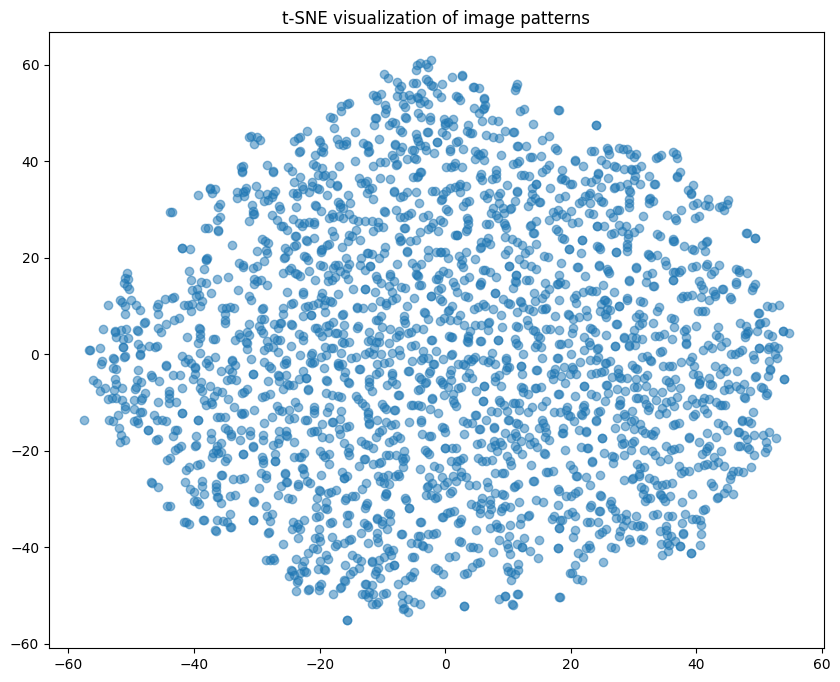

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# データが (2500, 28, 28) の形状と仮定
data = wave1  # 実際のデータに置き換え

# 各画像を平坦化: (10000, 784)
flattened_data = data.reshape(2500, 28*28)

# t-SNEで2次元に削減
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(flattened_data)

# 結果をプロット
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE visualization of image patterns')
plt.show()

動画を保存しました: mask_pattern_rough_2m.mp4


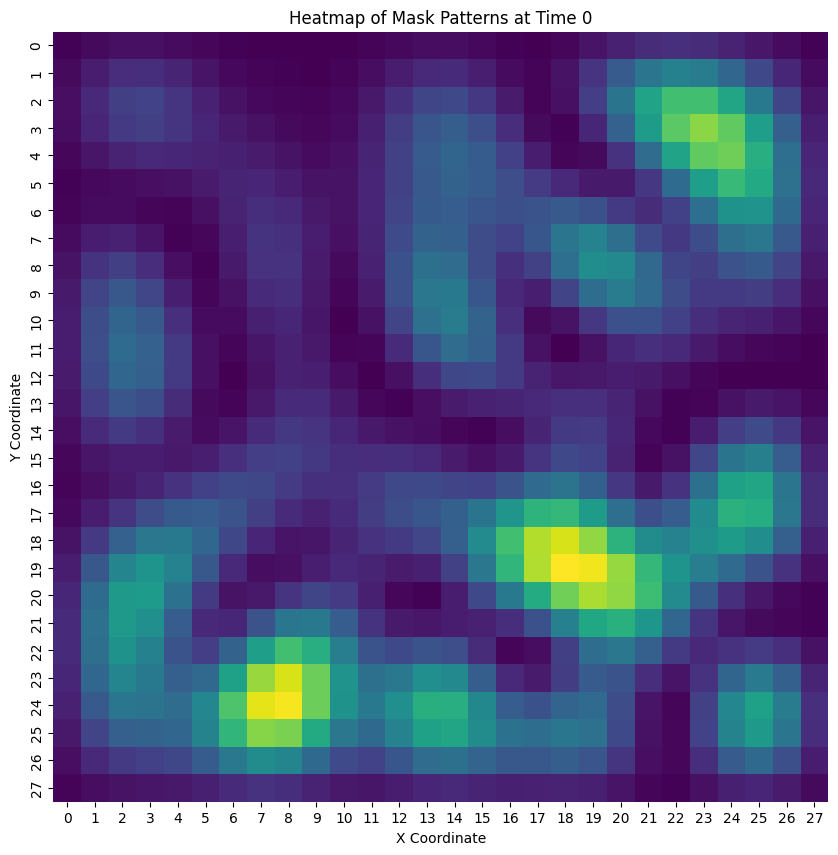

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

# 保存する動画のファイル名
video_filename = "mask_pattern_rough_2m.mp4"  # MP4形式で保存
# video_filename = "mask_patterns.gif"  # GIF形式で保存する場合

# データの例（実際のデータをmaskに代入すること）
# mask = np.random.rand(10, 28, 28)  # (時刻, X, Y)

t_max = mask.shape[0]  # データの最大時刻数

fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    """ アニメーションのフレーム更新 """
    ax.clear()
    sns.heatmap(mask[frame, :, :], cmap="viridis", cbar=False, ax=ax)
    ax.set_title(f"Heatmap of Mask Patterns at Time {frame}")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

ani = animation.FuncAnimation(fig, update, frames=t_max, interval=200)

# # 動画をMP4形式で保存（FFmpegが必要）
ani.save(video_filename, writer="ffmpeg", fps=5, dpi=100)

# GIFで保存する場合（Pillowを使用）
# ani.save(video_filename, writer="pillow", fps=5)

print(f"動画を保存しました: {video_filename}")


100%|██████████| 784/784 [00:08<00:00, 93.70it/s]


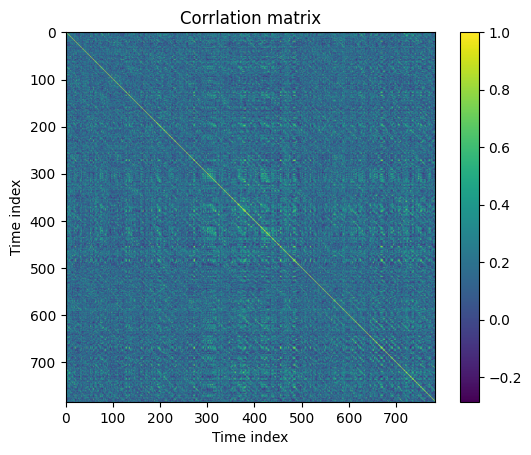

In [8]:
time_length = 784
num_x_pixel=28
num_y_pixel = 28
corr = np.zeros((time_length,time_length))
for n0 in tqdm( range(time_length) ):
    for n1 in range(time_length):
        corr[n0,n1] = np.corrcoef(mask[n0].reshape(num_x_pixel*num_y_pixel),mask[n1].reshape(num_x_pixel*num_y_pixel))[0,1]

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.set_title("Corrlation matrix")
ax.set_xlabel("Time index")
ax.set_ylabel("Time index")
cc = ax.imshow(corr)
fig.colorbar(cc)
plt.show()